In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install torchinfo opendatasets wandb munch transformers --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
import random
import cv2
import numpy as np
import pandas as pd
import os
import time
import copy
import opendatasets as od
import torch
import torch.nn as nn

from PIL import Image
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch import optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
# model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [ ]:
NUMWORKERS = os.cpu_count()
IMAGE_CHANNELS = 3
NUM_CLASSES = 196
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
SCALE = 1.1
BATCHSIZE=16

#DIR CONFIGS
DATA_PATH = Path('/content/stanford-cars-dataset')
META_PATH = Path(os.path.join(DATA_PATH,"car_devkit","devkit"))
CARS_TRAIN_PATH = Path(os.path.join(DATA_PATH,"cars_train","cars_train"))
CARS_TEST_PATH = Path(os.path.join(DATA_PATH,"cars_test","cars_test"))

# PRETRAINED = 'google/vit-large-patch16-224-in21k'
# HIDDEN_STATE = 1024
# IMG_SIZE = 224
# PRETRAINED = 'google/vit-base-patch16-224'
# HIDDEN_STATE =  768
IMG_SIZE = 384
PRETRAINED = 'google/vit-base-patch16-384'
HIDDEN_STATE =  768

In [ ]:
def set_seeds(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED
    """
    random.seed(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

def denormalize(images, means=IMAGENET_MEAN, stds=IMAGENET_STD,device=get_device()):
    """
    Returns the denormalized image.
    """
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [00:23<00:00, 84.2MB/s]


Data

The data is analyzed in this notebook

In [ ]:
class DefaultDataset(Dataset):
    def __init__(self, data_df,
                 transform = None,
                 is_test: bool = False):
        self.data_df = data_df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        # Get image details
        img_details = self.data_df.iloc[idx]

        img_path = img_details["file_path"]
        # image = cv2.imread(img_path)
        # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(img_path)
        img = image.convert("RGB")

        if self.transform:
            img = self.transform(img).to(torch.float)
        else:
            transform = transforms.ToTensor()
            img = transform(img).to(torch.float)

        if self.is_test:
            return img
        else:
            class_label = torch.tensor(img_details["class_idx"], dtype=torch.long)
            return (img, class_label)

def get_transforms(type):
    if type == 'train':
        train_transform = transforms.Compose([
            transforms.Resize((int(IMG_SIZE * SCALE),
                               int(IMG_SIZE * SCALE))),
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN,
                                 std=IMAGENET_STD)
        ])
        return train_transform

    elif type == 'test':
        val_test_transform = transforms.Compose([
            transforms.Resize(int(IMG_SIZE * SCALE)),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN,
                                 std=IMAGENET_STD)
        ])
        return val_test_transform

def create_train_df(labels):
    cars_train_annos = loadmat(Path(META_PATH) / 'cars_train_annos.mat')
    train_data = [[val.flat[0] for val in line] for line in cars_train_annos["annotations"][0]]
    columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_idx", "fname"]
    train_df = pd.DataFrame(train_data, columns=columns)
    train_df["class_idx"] = train_df["class_idx"] - 1
    train_df = train_df.merge(labels, left_on='class_idx', right_index=True)
    func = lambda x: os.path.join(CARS_TRAIN_PATH, x)
    train_df["file_path"] = train_df["fname"].apply(func)
    return train_df

def create_test_df():
    cars_test_annos = loadmat(Path(META_PATH) / 'cars_test_annos.mat')
    test_data = [[val.flat[0] for val in line] for line in cars_test_annos["annotations"][0]]
    columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "fname"]
    test_df = pd.DataFrame(test_data, columns=columns)
    func = lambda x: os.path.join(CARS_TEST_PATH, x)
    test_df["file_path"] = test_df["fname"].apply(func)
    return test_df

def create_labels():
    cars_meta = loadmat(Path(META_PATH) / 'cars_meta.mat')
    labels = [car for car in cars_meta["class_names"][0]]
    labels = pd.DataFrame(labels, columns=["class_labels"])
    labels['class_labels'] = labels['class_labels'].str.replace(' ', '_')
    return labels

def get_data():
    labels = create_labels()
    train_df = create_train_df(labels)
    test_df = create_test_df()
    train_df, val_df = train_test_split(
        train_df,
        train_size=0.8,
        random_state=42,
        stratify=train_df["class_idx"]
    )
    return train_df, val_df, test_df

def create_dataloaders(train_df: pd.DataFrame,
                       val_df: pd.DataFrame,
                       test_df: pd.DataFrame):
    train_transform = get_transforms("train")
    val_test_transform = get_transforms("test")

    # Create the training, validation, and test datasets using the appropriate transforms
    train_dataset = DefaultDataset(data_df=train_df, transform=train_transform, is_test=False)
    val_dataset = DefaultDataset(data_df=val_df, transform=val_test_transform, is_test=False)
    test_dataset = DefaultDataset(data_df=test_df, transform=val_test_transform, is_test=True)

    # Create the training, validation, and test dataloaders using the appropriate datasets and batch size
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCHSIZE,
        shuffle=True,
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=BATCHSIZE,
        shuffle=False,  # Do not shuffle the data
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=BATCHSIZE * 2,
        shuffle=False,  # Do not shuffle the data
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_df, val_df, test_df = get_data()
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(train_df, val_df, test_df)

Model

In [ ]:
class ViT(nn.Module):
    def __init__(self, config=ViTConfig(),
               num_classes=NUM_CLASSES,
               model_checkpoint=PRETRAINED):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
#         for param in self.vit.parameters():
#             param.requires_grad = False
        self.classifier =  nn.Sequential(
            nn.Linear(HIDDEN_STATE, out_features=num_classes))
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.1),
#             nn.Linear(in_features=512, out_features=num_classes)
#         )

        self.initialize_weights()

    def forward(self, x):
        x = self.vit(x)['last_hidden_state']
        # Use the embedding of [CLS] token
        output = self.classifier(x[:, 0, :])
        return output

    def initialize_weights(self):
        # Initialize the classifier weights using Xavier uniform distribution
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

In [ ]:
model= ViT()

Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torchinfo import summary

summary(model,
        input_size=(16, 3, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                              [16, 3, 384, 384] [16, 196]       --              True
├─ViTModel (vit)                                                       [16, 3, 384, 384] [16, 577, 768]  --              True
│    └─ViTEmbeddings (embeddings)                                      [16, 3, 384, 384] [16, 577, 768]  443,904         True
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [16, 3, 384, 384] [16, 576, 768]  590,592         True
│    │    └─Dropout (dropout)                                          [16, 577, 768]  [16, 577, 768]  --              --
│    └─ViTEncoder (encoder)                                            [16, 577, 768]  [16, 577, 768]  --              True
│    │    └─ModuleList (layer)                                         --              --              85,054,464      Tr

Model Performance before training

In [ ]:
def evaluate_batch(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall

In [ ]:
def evaluate(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module):
    model.eval()
    device = get_device()
    test_loss, test_acc, test_precision, test_recall = 0, 0, 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = criterion(test_pred_logits, y)
            test_loss += loss.item()

            #Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            batch_acc,batch_precision,batch_recall = evaluate_batch(y,test_pred_labels)

            test_acc += batch_acc
            test_precision += batch_precision
            test_recall += batch_recall

    # Calculate average metrics per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_precision = test_precision / len(dataloader)
    test_recall = test_recall / len(dataloader)

    return test_loss, test_acc, test_precision, test_recall

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_precision, test_recall = evaluate(model,val_dataloader,criterion)

test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f'''                         Metrics before training
 val_loss: {test_loss:.4f} | val_acc: {test_acc:.4f} | val_f1_score: {test_f1_score:.4f} ''')

                         Metrics before training
 val_loss: 5.9913 | val_acc: 0.0031 | val_f1_score: 0.0017 


predict a single image before training

In [ ]:
labels = create_labels()

def predict(img_path,model):
    device = get_device()
    transform = get_transforms('test')
    img = Image.open(img_path)
    img = transform(img)
    output = model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return labels.iloc[prediction]

In [ ]:
sample = val_df.sample()
sample

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_idx,fname,class_labels,file_path
871,69,109,461,284,54,00872.jpg,Chevrolet_Corvette_Convertible_2012,/content/stanford-cars-dataset/cars_train/cars...


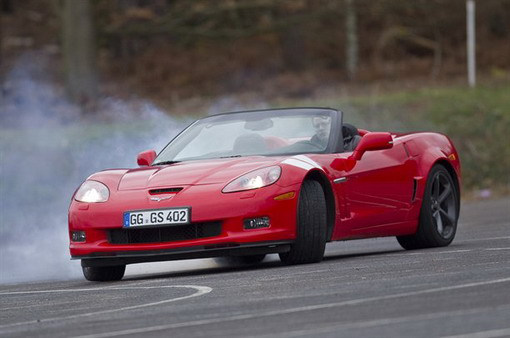

In [ ]:
img = Image.open(sample['file_path'].item())
img

In [ ]:
labels.iloc[sample['class_idx'].item()]

class_labels    Chevrolet_Corvette_Convertible_2012
Name: 54, dtype: object

prediction

In [ ]:
predict(sample['file_path'].item(),model)

class_labels    Chrysler_Sebring_Convertible_2010
Name: 76, dtype: object

Model Training

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def save_model(model_save_path, model,optimizer,epoch,avg_metrics):
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(
            {
                'epoch': epoch,
                'avg_metrics':avg_metrics,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            },
            f=model_save_path
        )

In [ ]:
def train_model(model,train_dataloader,test_dataloader,config):
    device = get_device()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate,weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    wandb.init(project=config.project,name=config.experiment_name,config=config)

    for epoch in tqdm(range(config.start_iter,config.epochs)):

        model.train()
        train_loss, train_acc, train_precision, train_recall = 0, 0, 0, 0
        for  (X, y) in (train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            if config.grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), config.grad_clip)
            optimizer.step()

            with torch.no_grad():
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                batch_acc,batch_precision,batch_recall = evaluate_batch(y,y_pred_class)

                train_acc += batch_acc
                train_precision += batch_precision
                train_recall += batch_recall

        # calculate avg metrics per batch
        avg_metrics = OrderedDict()
        avg_metrics['lr'] = optimizer.param_groups[0]['lr']
        avg_metrics['train_loss'] = train_loss / len(train_dataloader)
        avg_metrics['train_acc'] = train_acc / len(train_dataloader)
        avg_metrics['train_precision'] = train_precision/ len(train_dataloader)
        avg_metrics['train_recall'] = train_recall/ len(train_dataloader)
        avg_metrics['train_f1'] = (2 * (train_precision * train_recall) / (train_precision + train_recall)) / len(train_dataloader)

        test_loss, test_acc, test_precision, test_recall = evaluate(model,test_dataloader,criterion)
        avg_metrics['val_loss'] = test_loss
        avg_metrics['val_acc'] = test_acc
        avg_metrics['val_precision'] = test_precision
        avg_metrics['val_recall'] = test_recall
        avg_metrics['val_f1'] = 2 * (test_precision * test_recall) / (test_precision + test_recall)

        scheduler.step()

        wandb.log(avg_metrics, step=epoch+1)
        print(f"Epoch : {epoch+1}")
        print(f"Train Loss : {avg_metrics['train_loss']: .4f} | Train Acc : {avg_metrics['train_acc']: .4f} | Train F1 : {avg_metrics['train_f1']: .4f} ")
        print(f"Val Loss   : {avg_metrics['val_loss']: .4f}   | Val Acc : {avg_metrics['val_acc']: .4f}     | Val F1   : {avg_metrics['val_f1']: .4f}")

        if (epoch+1) % config.checkpoint_period == 0:
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'model_chkpt_{epoch+1}_acc_{avg_metrics["val_acc"]: .3f}.pth')
            #save_model(model_save_path, model,optimizer,epoch,avg_metrics)
        if avg_metrics['val_acc']  > best_acc and avg_metrics['val_acc'] > 0.5:
            best_acc = avg_metrics['val_acc']
            best_model_wts = copy.deepcopy(model.state_dict())
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'{config.experiment_name}_best_model.pth')
            save_model(model_save_path, model,optimizer,epoch+1,avg_metrics)

    wandb.finish()
    print()
    print(f"Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
from munch import Munch
config = dict()
config.update({
    "project":"kaggle_vit",
    "experiment_name":"vit_b_16_384_FineTune_model_Adam_normal_head_bs_16",
    "models_dir": "models",
    "history_dir": "history",
    "start_iter": 0,
    "epochs": 15,
    "checkpoint_period": 3,
    "grad_clip": 1.0,
    "metric": "val_f1",
    "optimizer": "Adam",
    "learning_rate": 0.0001,
    'weight_decay': 0.00001,
    "step_size" : 5,
    "gamma": 0.97 ,
    "batch_size": BATCHSIZE
})
config = Munch(config)

In [ ]:
set_seeds(42)
model = ViT().to(get_device())
trained_model = train_model(model,train_dataloader,val_dataloader,config)

Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: vasanthsai26. Use `wandb login --relogin` to force relogin


  7%|▋         | 1/15 [13:12<3:05:01, 792.98s/it]

Epoch : 1
Train Loss :  4.4616 | Train Acc :  0.0925 | Train F1 :  0.0547 
Val Loss   :  2.7898   | Val Acc :  0.3210     | Val F1   :  0.2048
Epoch : 2
Train Loss :  2.0828 | Train Acc :  0.5021 | Train F1 :  0.3548 
Val Loss   :  1.3420   | Val Acc :  0.6515     | Val F1   :  0.5034
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 13%|█▎        | 2/15 [26:28<2:52:11, 794.74s/it]

Epoch : 3
Train Loss :  1.1213 | Train Acc :  0.7374 | Train F1 :  0.6035 
Val Loss   :  1.0215   | Val Acc :  0.7330     | Val F1   :  0.5973
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 20%|██        | 3/15 [39:49<2:39:26, 797.21s/it]

Epoch : 4
Train Loss :  0.7750 | Train Acc :  0.8154 | Train F1 :  0.7045 
Val Loss   :  0.8279   | Val Acc :  0.7690     | Val F1   :  0.6441
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 27%|██▋       | 4/15 [53:06<2:26:11, 797.40s/it]

Epoch : 5
Train Loss :  0.6259 | Train Acc :  0.8568 | Train F1 :  0.7632 
Val Loss   :  0.6989   | Val Acc :  0.7966     | Val F1   :  0.6789
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 33%|███▎      | 5/15 [1:06:24<2:12:53, 797.38s/it]

Epoch : 6
Train Loss :  0.5394 | Train Acc :  0.8705 | Train F1 :  0.7840 
Val Loss   :  0.7285   | Val Acc :  0.8076     | Val F1   :  0.6934
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 40%|████      | 6/15 [1:19:43<1:59:41, 797.97s/it]

Epoch : 7
Train Loss :  0.4746 | Train Acc :  0.8891 | Train F1 :  0.8130 
Val Loss   :  0.6806   | Val Acc :  0.8164     | Val F1   :  0.7061
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 47%|████▋     | 7/15 [1:33:01<1:46:25, 798.17s/it]

Epoch : 8
Train Loss :  0.4879 | Train Acc :  0.8848 | Train F1 :  0.8073 
Val Loss   :  0.6993   | Val Acc :  0.8185     | Val F1   :  0.7082
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 53%|█████▎    | 8/15 [1:46:18<1:33:03, 797.62s/it]

Epoch : 9
Train Loss :  0.4489 | Train Acc :  0.8950 | Train F1 :  0.8232 
Val Loss   :  0.6095   | Val Acc :  0.8305     | Val F1   :  0.7235
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 67%|██████▋   | 10/15 [2:12:48<1:06:21, 796.21s/it]

Epoch : 10
Train Loss :  0.4243 | Train Acc :  0.8951 | Train F1 :  0.8214 
Val Loss   :  0.6319   | Val Acc :  0.8305     | Val F1   :  0.7237
Epoch : 11
Train Loss :  0.4020 | Train Acc :  0.9041 | Train F1 :  0.8343 
Val Loss   :  0.5936   | Val Acc :  0.8465     | Val F1   :  0.7473
[INFO] Saving model to: models/vit_b_16_384_FineTune_model_Adam_normal_head_bs_16_best_model.pth


 73%|███████▎  | 11/15 [2:26:10<53:11, 797.80s/it]  

In [ ]:
labels = create_labels()
class_labels_dict = labels['class_labels'].to_dict()

def evaluate_model(model, val_loader, class_labels):
    model.eval()
    device = get_device()
    total_samples = 0
    correct_predictions = 0

    class_correct = torch.zeros(len(class_labels))
    class_total = torch.zeros(len(class_labels))

    result_dict = dict()

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                prediction = predicted[i]
                class_correct[label] += (prediction == label).item()
                class_total[label] += 1

    print('Correctly predicted classes:')
    for i in range(len(class_labels)):
        class_name = class_labels[i]
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{class_name}: {accuracy:.2f}%')

    print('\nIncorrectly predicted classes:')
    for i in range(len(class_labels)):
        class_name = class_labels[i]
        incorrect_samples = class_total[i] - class_correct[i]
        accuracy = 100 * incorrect_samples / class_total[i]
        print(f'{class_name}: {accuracy:.2f}%')

    print('\nTotal samples:')
    print(f'Total: {total_samples}')
    accuracy = 100 * correct_predictions / total_samples
    print(f'Accuracy: {accuracy:.2f}%')

In [ ]:
evaluate_model(trained_model, val_dataloader, class_labels_dict)